# 4.0_SynAnalyzer_PlotImarisResults.ipynb
Created by: JFranco | 25 SEP 2024 | Env: SynAnalyzer | Last run: 25 SEP 2024

This Python notebook allows a user to review the XYZ data as it was originally taken from the Imaris Stats Files. The main plots produced for each data set (i.e., either pre or post synaptic surface reconstructions) are:
(1) Distribution of surface volumes
(2) Distribution of surface intensities for each channel in the original image
(3) Number of surfaces per HC 
*For each of these plots the notebook also allows the user to compare conditions

REQUIRES: 
   
    - All files organized according to SynAnalyzer structure 
    - XYZ csv files produced by the 1.0_SynAnalyzer_ConvertImarisStatsFiles notebooks (either local or through Google Collab)
    - Imaging metadata sheet compiled by 3.0_SynAnalyzer_CompileImagingMD (either v1 or v2) 
    - Sample metadata sheet either manually generated or compiled by 3.1_SynAnalyzer_CompileSampleMetadata
    - User specifications:
        - Preps to include in the analysis
        - Frequency regions to analyze
        - Whether to plot pre-, post-, or both data sets

In [ ]:
#     *** IMPORT PACKAGES **
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns
from statistics import median

In [ ]:
#                   *** GET TIME OF ANALYSIS START ***
# could turn this into a module?
toa = str(datetime.datetime.today()).split()                                   #Time of analysis
today = toa[0]
now = toa[1]
timestamp = today.replace('-','')+'-'+now.replace(':','')[:6]

### SETUP PARAMETERS FOR THIS ANALYSIS 

In [ ]:
#     *** WHAT TO ANALYZE // WHERE TO GET/STORE **
# Batch analysis directory (where the new metadata sheet will be stored)
batchID = 'SynAnalysis_BclwSNHL_NeonatalAAV'     
# Preps that are included in the analysis
preps = ['WSS_038','WSS_039','WSS_040','WSS_041']
# Frequencies to include in analysis
freqs = [16,32]
# Surfaces to include in the analysis
#surfs = ['PreSyn','PostSyn']
surfs = ['PreSyn']
# Metadata fields to grab & use as plotting parameters
mdSFields = ['AnimalID','Sex','DOB','Genotype','Treatment','NoiseExposed']
mdIFields = ['Freq','NoHCRecon']
# Define condition (used for plotting) - Variables declared above and pasted here for reference
condToTest = ['Treatment','NoiseExposed']
condOneVals = ['Uninjected','mTagBFP','HABclw']
condTwoVals = ['Sham','Exposed']
conditions = ['UnInj\nSham','UnInj\nExposed','CtrlInj\nSham','CtrlInj\nExposed','BclwInj\nSham','BclwInj\nExposed']
# Parameters for plotting
pltOrder = conditions
colors = {pltOrder[0]:'goldenrod' , pltOrder[1]:'gold', pltOrder[2]:'darkslateblue', pltOrder[3]:'slateblue' , pltOrder[4]:'blueviolet', pltOrder[5]:'mediumorchid'}
ecdfColors = ['goldenrod','gold', 'darkslateblue', 'slateblue', 'blueviolet', 'mediumorchid']

# Directories 
#   existing ones 
dirMain = '/Users/joyfranco/Dropbox (Partners HealthCare)/JF_Shared/Data/WSS/'
dirBA = dirMain+'BatchAnalysis/'+batchID+'/'
dirMD = dirBA+'Metadata/'
dirXYZs = dirBA+'XYZCSVs/'
#   ones that need to be made    
dirRes = dirBA+'SAR.Results/'
dirTR = dirRes+timestamp+'/'

# Files to access
fnMDSamp = batchID+'.Metadata.Samples.csv'
fnMDIms = batchID+'.Metadata.Imaging.csv'
fnBM = 'SynAnalyzerBatchMaster.csv'

### INITIALIZE DIRECTORY AND FILES FOR ANALYSIS

In [ ]:
#    *** INITIALIZE RUN SPECIFIC DIRECTORY ETC FOR STORING RESULTS **
# Create directory for storing spreadsheets and summary plots for this run
if not os.path.exists(dirRes): os.mkdir(dirRes)
if not os.path.exists(dirTR): os.mkdir(dirTR)

In [ ]:
#    *** LOAD MD SHEETS **
# Sample metadata sheet that include animal and condition info
dfSamps = pd.read_csv(dirMD+fnMDSamp)
dfSamps.reset_index(inplace=True)
# Imaging metadata sheet that includes frequency and NoHC info
dfIms = pd.read_csv(dirMD+fnMDIms)
dfIms.drop('Unnamed: 0', axis=1, inplace=True)
#dfIms.reset_index(inplace=True)

In [ ]:
# Create a df that has every XYZ surface created in Imaris for the images in the MD sheet
#   that meet the user specifications

# Subset the imaging metadataframe to only include the images that are the right frequency
#    This df will be used as a "master" sheet for tracking summary values per image
dfIms = dfIms[dfIms['Freq'].isin(freqs)]
dfIms.reset_index(inplace=True)
dfIms.drop('index', axis=1, inplace=True)

###   COMPILE DATA FROM ALL IMAGES INCLUDED IN ANALYSIS

In [ ]:
# Iterate through the images and compile XZYz data 
#    Create df for storing all XYZs across all images included in this run
dfXYZsAll = pd.DataFrame()
for im in dfIms['ImageName']:
    # Get key md from imaging and sample md sheet
    inIm = dfIms.index[dfIms['ImageName']==im].tolist()[0]
    samp = dfIms.loc[inIm]['SlideID']
    freq = dfIms.loc[inIm]['Freq']
    noHC = dfIms.loc[inIm]['NoHCRecon']
    inSamp = dfSamps.index[dfSamps['SampleID']==samp].tolist()[0]
    vals = list()
    for field in mdSFields:
        val = dfSamps.loc[inSamp][field]
        dfIms.at[inIm, field]=val
        vals.append(val)
    valCount = len(vals)
    v = 0
    # Define condition (used for plotting) - Variables declared above and pasted here for reference
    #condToTest = ['Treament','NoiseExposed']
    #condOneVals = ['Uninjected','mTagBFP','HABclw']
    #condTwoVals = ['Sham','Exposed']
    #conditions = ['UnInj\nSham','UnInj\nExposed','CtrlInj\nSham','CtrlInj\nExposed','BclwInj\nSham','BclwInj\nExposed']
    if ((dfIms.loc[inIm][condToTest[0]] == condOneVals[0]) & (dfIms.loc[inIm][condToTest[1]] == condTwoVals[0])):
        # Condition = Uninjected Sham 
        cond = conditions[0]
    elif ((dfIms.loc[inIm][condToTest[0]] == condOneVals[0]) & (dfIms.loc[inIm][condToTest[1]] == condTwoVals[1])):
        # Condition = Uninjected Exposed 
        cond = conditions[1]
    elif ((dfIms.loc[inIm][condToTest[0]] == condOneVals[1]) & (dfIms.loc[inIm][condToTest[1]] == condTwoVals[0])):
        # Condition = CTRL Injected Sham 
        cond = conditions[2]
    elif ((dfIms.loc[inIm][condToTest[0]] == condOneVals[1]) & (dfIms.loc[inIm][condToTest[1]] == condTwoVals[1])):
        # Condition = CTRL Injected Exposed 
        cond = conditions[3]
    elif ((dfIms.loc[inIm][condToTest[0]] == condOneVals[2]) & (dfIms.loc[inIm][condToTest[1]] == condTwoVals[0])):
        # Condition = HABclw Injected Sham
        cond = conditions[4]
    elif ((dfIms.loc[inIm][condToTest[0]] == condOneVals[2]) & (dfIms.loc[inIm][condToTest[1]] == condTwoVals[1])):
        # Condition = HABclw Injected Exposed 
        cond = conditions[5]
    dfIms.at[inIm, 'Condition']=cond
    
    # Iterate through the surface types to include
    for surf in surfs:
        # Setup the filename to open
        fnXYZ = im+'.XYZ.'+surf+'.csv'
        # Load the XYZ df 
        dfXYZ = pd.read_csv(dirXYZs+fnXYZ)
        # Add important md to each row
        dfXYZ['Freq']=freq
        dfXYZ['Surf']=surf
        dfXYZ['Condition']=cond
        for field in mdSFields:
            dfXYZ[field]=vals[v]
            v=v+1
        # Add summary data to image df
        dfIms.at[inIm, surf+'_Count']=len(dfXYZ)
        dfIms.at[inIm, 'Avg_'+surf+'_perHC']=len(dfXYZ)/noHC
        dfIms.at[inIm, surf+'_MeanVol_um3']=dfXYZ['Volume_um3'].mean()
        dfIms.at[inIm, surf+'_MeanIntCh1']=dfXYZ['uIntCh_1'].mean()
        dfIms.at[inIm, surf+'_MeanIntCh2']=dfXYZ['uIntCh_2'].mean()
        dfIms.at[inIm, surf+'_MeanIntCh3']=dfXYZ['uIntCh_3'].mean()
        dfIms.at[inIm, surf+'_MeanIntCh4']=dfXYZ['uIntCh_4'].mean()

        # Calculate the mean normalized vals for each surface
        dfXYZ['uNormVol'] = dfXYZ['Volume_um3']/dfIms.loc[inIm][surf+'_MeanVol_um3']
        dfXYZ['uNormIntCh1'] = dfXYZ['uIntCh_1']/dfIms.loc[inIm][surf+'_MeanIntCh1']
        dfXYZ['uNormIntCh2'] = dfXYZ['uIntCh_2']/dfIms.loc[inIm][surf+'_MeanIntCh2']
        dfXYZ['uNormIntCh3'] = dfXYZ['uIntCh_3']/dfIms.loc[inIm][surf+'_MeanIntCh3']
        dfXYZ['uNormIntCh4'] = dfXYZ['uIntCh_4']/dfIms.loc[inIm][surf+'_MeanIntCh4']
        
        # Add it to the main df
        dfXYZsAll = pd.concat([dfXYZsAll,dfXYZ])

# Save the updated sheets
dfXYZsAll.to_csv(dirTR+batchID+'.XYZSummary.csv') 
dfIms.to_csv(dirTR+batchID+'.ImageSummary.csv') 

### GENERATE PLOTS

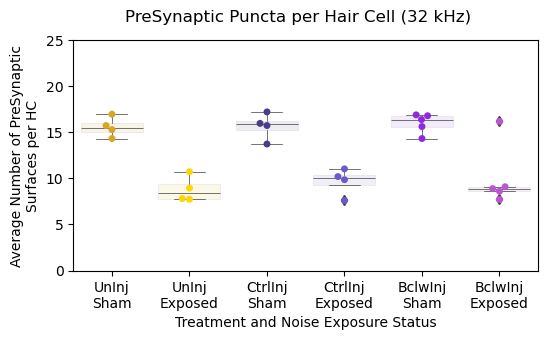

In [11]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'AvgPreSynPerHC'
plottype = 'BoxSwarm'
region = 32
title = 'PreSynaptic Puncta per Hair Cell ('+str(region)+' kHz)'
hue = 'Condition'
x = 'Condition'
y = 'Avg_PreSyn_perHC'
ymin = 0
ymax = 25
xlab = 'Treatment and Noise Exposure Status'
ylab = 'Average Number of PreSynaptic\nSurfaces per HC'

# *** MAKE PLOT ***
fig= plt.figure(figsize=(6,3))
fig.suptitle(title)
ax1 = sns.swarmplot(data=dfIms[(dfIms['Freq']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,legend = False, dodge = False)
sns.boxplot(data=dfIms[(dfIms['Freq']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,boxprops={'alpha': 0.1}, ax=ax1, dodge = False,linewidth=.5)
ax1.set_ylim((ymin, ymax))
ax1.set(xlabel=xlab)
ax1.set(ylabel=ylab)
ax1.get_legend().remove()

# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

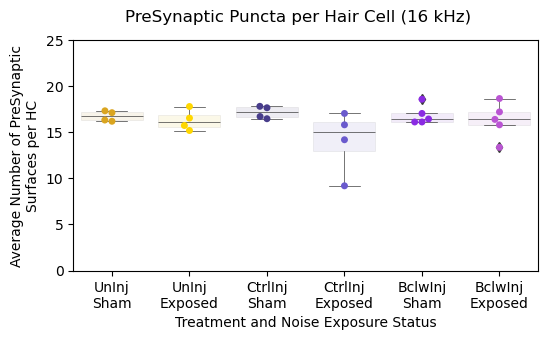

In [14]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'AvgPreSynPerHC'
plottype = 'BoxSwarm'
region = 16
title = 'PreSynaptic Puncta per Hair Cell ('+str(region)+' kHz)'
hue = 'Condition'
x = 'Condition'
y = 'Avg_PreSyn_perHC'
ymin = 0
ymax = 25
xlab = 'Treatment and Noise Exposure Status'
ylab = 'Average Number of PreSynaptic\nSurfaces per HC'

# *** MAKE PLOT ***
fig= plt.figure(figsize=(6,3))
fig.suptitle(title)
ax1 = sns.swarmplot(data=dfIms[(dfIms['Freq']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,legend = False, dodge = False)
sns.boxplot(data=dfIms[(dfIms['Freq']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,boxprops={'alpha': 0.1}, ax=ax1, dodge = False,linewidth=.5)
ax1.set_ylim((ymin, ymax))
ax1.set(xlabel=xlab)
ax1.set(ylabel=ylab)
ax1.get_legend().remove()

# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

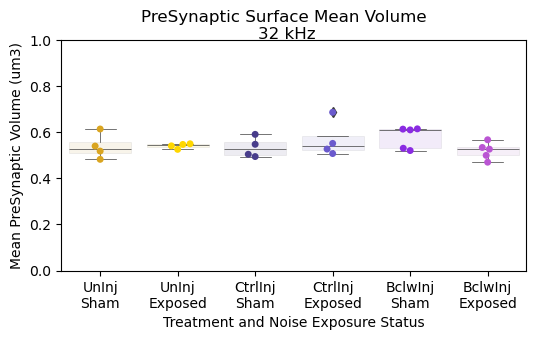

In [16]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PreSynMeanVol'
plottype = 'BoxSwarm'
region = 32
title = 'PreSynaptic Surface Mean Volume \n'+str(region)+' kHz\n'
hue = 'Condition'
x = 'Condition'
y = 'PreSyn_MeanVol_um3'
ymin = 0
ymax = 1
xlab = 'Treatment and Noise Exposure Status'
ylab = 'Mean PreSynaptic Volume (um3)'

# *** MAKE PLOT ***
fig= plt.figure(figsize=(6,3))
fig.suptitle(title)
ax1 = sns.swarmplot(data=dfIms[(dfIms['Freq']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,legend = False, dodge = False)
sns.boxplot(data=dfIms[(dfIms['Freq']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,boxprops={'alpha': 0.1}, ax=ax1, dodge = False,linewidth=.5)
ax1.set_ylim((ymin, ymax))
ax1.set(xlabel=xlab)
ax1.set(ylabel=ylab)
ax1.get_legend().remove()

# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

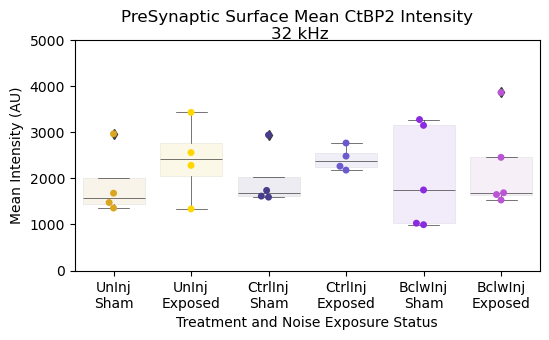

In [20]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PreSynMeanCtBP2Int'
plottype = 'BoxSwarm'
region = 32
title = 'PreSynaptic Surface Mean CtBP2 Intensity \n'+str(region)+' kHz\n'
hue = 'Condition'
x = 'Condition'
y = 'PreSyn_MeanIntCh1'
ymin = 0
ymax = 5000
xlab = 'Treatment and Noise Exposure Status'
ylab = 'Mean Intensity (AU)'

# *** MAKE PLOT ***
fig= plt.figure(figsize=(6,3))
fig.suptitle(title)
ax1 = sns.swarmplot(data=dfIms[(dfIms['Freq']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,legend = False, dodge = False)
sns.boxplot(data=dfIms[(dfIms['Freq']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,boxprops={'alpha': 0.1}, ax=ax1, dodge = False,linewidth=.5)
ax1.set_ylim((ymin, ymax))
ax1.set(xlabel=xlab)
ax1.set(ylabel=ylab)
ax1.get_legend().remove()

# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

In [ ]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PreSynMeanCalb2Int'
plottype = 'BoxSwarm'
region = 32
title = 'PreSynaptic Surface Mean Calb2 Intensity \n'+str(region)+' kHz\n'
hue = 'Condition'
x = 'Condition'
y = 'PreSyn_MeanIntCh2'
ymin = 0
ymax = 30000
xlab = 'Treatment and Noise Exposure Status'
ylab = 'Average Number of PreSynaptic\nSurfaces per HC'

# *** MAKE PLOT ***
fig= plt.figure(figsize=(6,3))
fig.suptitle(title)
ax1 = sns.swarmplot(data=dfIms[(dfIms['Freq']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,legend = False, dodge = False)
sns.boxplot(data=dfIms[(dfIms['Freq']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,boxprops={'alpha': 0.1}, ax=ax1, dodge = False,linewidth=.5)
ax1.set_ylim((ymin, ymax))
ax1.set(xlabel=xlab)
ax1.set(ylabel=ylab)
ax1.get_legend().remove()

# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

In [ ]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PreSynVolumes'
plottype = 'ECDF'
region = 16
title = 'PreSynaptic Surface Volumes \n'+str(region)+' kHz\n'
surfType = 'PreSyn'
hue = 'Condition'
x = 'Volume_um3'
xlab = 'Volume (um3)'
ylab = 'Proportion of Surfaces'

# *** MAKE PLOT ***
plt.figure(figsize=(6, 3))
ax = sns.ecdfplot(data=dfXYZsAll[(dfXYZsAll['Freq']==region)&(dfXYZsAll['Surf']==surfType)],x=x, hue=hue, palette=colors)
ax.set_title(title)
ax.set(xlabel=xlab)
ax.set(ylabel=ylab)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left',  fancybox=True, labels=conditions)
leg = ax.get_legend()
noHandles = len(leg.legend_handles)
i=0
for i in range(0, 6):
    leg.legend_handles[i].set_color(ecdfColors[i])

# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

In [ ]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PreSynVolumes'
plottype = 'ECDF'
region = 32
title = 'PreSynaptic Surface Volumes \n'+str(region)+' kHz\n'
surfType = 'PreSyn'
hue = 'Condition'
x = 'Volume_um3'
xlab = 'Volume (um3)'
ylab = 'Proportion of Surfaces'

# *** MAKE PLOT ***
plt.figure(figsize=(6, 3))
ax = sns.ecdfplot(data=dfXYZsAll[(dfXYZsAll['Freq']==region)&(dfXYZsAll['Surf']==surfType)],x=x, hue=hue, palette=colors)
ax.set_title(title)
ax.set(xlabel=xlab)
ax.set(ylabel=ylab)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left',  fancybox=True, labels=conditions)
leg = ax.get_legend()
noHandles = len(leg.legend_handles)
i=0
for i in range(0, 6):
    leg.legend_handles[i].set_color(ecdfColors[i])
    
# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

In [ ]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PreSynVolumes'
plottype = 'Hist'
region = 16
title = 'PreSynaptic Surface Volumes \n'+str(region)+' kHz\n'
surfType = 'PreSyn'
hue = 'Condition'
x = 'Volume_um3'
xlab = 'Volume (um3)'
ylab = 'Number of Surfaces'

# *** MAKE PLOT ***
plt.figure(figsize=(6, 3))
ax = sns.histplot(data=dfXYZsAll[(dfXYZsAll['Freq']==region)&(dfXYZsAll['Surf']==surfType)],x=x, hue=hue, hue_order=pltOrder,  palette=colors,kde=True)
ax.set_title(title)
ax.set(xlabel=xlab)
ax.set(ylabel=ylab)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left',  fancybox=True, labels=conditions)
leg = ax.get_legend()
noHandles = len(leg.legend_handles)
i=0
for i in range(0, 6):
    leg.legend_handles[i].set_color(ecdfColors[i])

# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

In [ ]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PreSynVolumes'
plottype = 'Hist'
region = 32
title = 'PreSynaptic Surface Volumes \n'+str(region)+' kHz\n'
surfType = 'PreSyn'
hue = 'Condition'
x = 'Volume_um3'
xlab = 'Volume (um3)'
ylab = 'Number of Surfaces'

# *** MAKE PLOT ***
plt.figure(figsize=(6, 3))
ax = sns.histplot(data=dfXYZsAll[(dfXYZsAll['Freq']==region)&(dfXYZsAll['Surf']==surfType)],x=x, hue=hue, hue_order=pltOrder,  palette=colors,kde=True)
ax.set_title(title)
ax.set(xlabel=xlab)
ax.set(ylabel=ylab)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left',  fancybox=True, labels=conditions)
leg = ax.get_legend()
noHandles = len(leg.legend_handles)
i=0
for i in range(0, 6):
    leg.legend_handles[i].set_color(ecdfColors[i])
    
# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

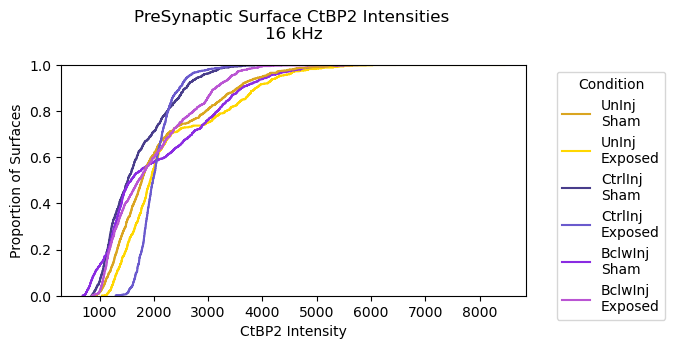

In [21]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PreSynCtBP2Int'
plottype = 'ECDF'
region = 16
title = 'PreSynaptic Surface CtBP2 Intensities \n'+str(region)+' kHz\n'
surfType = 'PreSyn'
hue = 'Condition'
x = 'uIntCh_1'
xlab = 'CtBP2 Intensity'
ylab = 'Proportion of Surfaces'

# *** MAKE PLOT ***
plt.figure(figsize=(6, 3))
ax = sns.ecdfplot(data=dfXYZsAll[(dfXYZsAll['Freq']==region)&(dfXYZsAll['Surf']==surfType)],x=x, hue=hue, palette=colors)
ax.set_title(title)
ax.set(xlabel=xlab)
ax.set(ylabel=ylab)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left',  fancybox=True, labels=conditions)
leg = ax.get_legend()
noHandles = len(leg.legend_handles)
i=0
for i in range(0, 6):
    leg.legend_handles[i].set_color(ecdfColors[i])
# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

IndexError: list index out of range

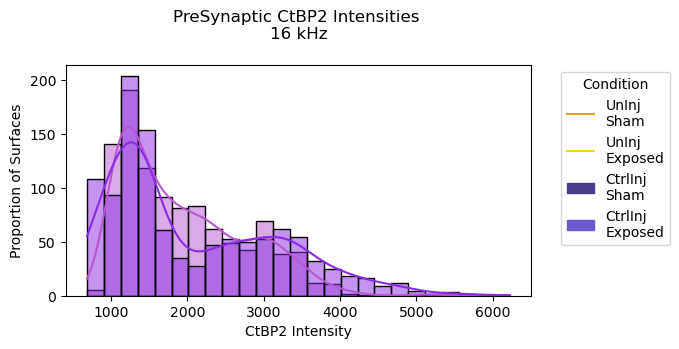

In [25]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PreSynCtBP2Int'
plottype = 'Hist'
region = 16
title = 'PreSynaptic CtBP2 Intensities \n'+str(region)+' kHz\n'
surfType = 'PreSyn'
hue = 'Condition'
x = 'uIntCh_1'
xlab = 'CtBP2 Intensity'
ylab = 'Proportion of Surfaces'

# *** MAKE PLOT ***
plt.figure(figsize=(6, 3))
ax = sns.histplot(data=dfXYZsAll[(dfXYZsAll['Freq']==region)&(dfXYZsAll['Surf']==surfType)&(dfXYZsAll['Treatment']=='HABclw')],x=x, hue=hue, hue_order=pltOrder,  palette=colors,kde=True)
ax.set_title(title)
ax.set(xlabel=xlab)
ax.set(ylabel=ylab)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left',  fancybox=True, labels=conditions)
leg = ax.get_legend()
noHandles = len(leg.legend_handles)
i=0
for i in range(0, 6):
    leg.legend_handles[i].set_color(ecdfColors[i])
    
# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')